# GEODOS data processing

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [159]:
dto = '/storage/stations/LS/GEODOS/2023/03/27/'
dto = '/storage/stations/LS/GEODOS/2023/05/30/'
dto = '/storage/stations/LS/GEODOS/2023/06/02/'
dto = '/storage/stations/LS/GEODOS/2023/06/08/'
dto = '/storage/stations/LS/GEODOS/2023/06/14/'


df = pd.DataFrame()
  
for fto in glob.iglob(dto + '*'): # generator, search immediate subdirectories 
    l=[]
    l.extend(range(0,1039))
    rdf = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='c',low_memory=False)
    rdf.drop(rdf[(rdf[1]!='$HIST')&(rdf[1]!='$HITS')].index, inplace=True)
    print(fto, rdf[(rdf[1]!='$HIST')].shape[0],rdf[(rdf[1]!='$HIST')].shape[0])
    df = pd.concat([df, rdf])
    
    
#df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
#df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

#df.drop(df[(df[1]!='$HIST')&(df[1]!='$HITS')].index, inplace=True)

print('end')

/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_16 285 285
/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_05 284 284
/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_02 281 281
/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_08 285 285
/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_23 284 284
/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_11 279 279
/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_15 282 282
/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_06 282 282
/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_01 285 285
/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_20 284 284
/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_12 284 284
/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_18 278 278
/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_22 285 285
/storage/stations/LS/GEODOS/2023/06/14/geodos.csv.2023-06-14_10 

In [160]:
START_HIST = 12 # Sloupec prvniho kanalu HIST
FIRST_CH = 17  # Sloupec prvniho kanalu bez sumu
LAST_CH = 36+1 # Sloupec posledni kanalu HIST

hist = df.loc[df[1]=='$HIST'].iloc[:,FIRST_CH:LAST_CH]
hist['time'] = df.loc[df[1]=='$HIST'].iloc[:,0]
hist['time'] = pd.to_datetime(hist['time'], unit='s')

hist['temperature'] = df.loc[df[1]=='$HIST'].iloc[:,6]
hist['pressure'] = df.loc[df[1]=='$HIST'].iloc[:,5]
hist['voltage'] = df.loc[df[1]=='$HIST'].iloc[:,7]
hist['current'] = df.loc[df[1]=='$HIST'].iloc[:,8]

hist.reset_index(inplace=True,drop=True)
#hist.set_index('time', drop=False, inplace=True)


## Add individual events to histogram

In [161]:
hits = df.loc[df[1]=='$HITS'].copy()
hits.iloc[:,2:] = hits.iloc[:,2:].apply(pd.to_numeric)
hits['time'] = df.loc[df[1]=='$HITS'].iloc[:,0]
hits['time'] = pd.to_datetime(hits['time'], unit='s')
#hits.set_index('time', inplace=True)
hits.reset_index(inplace=True,drop=True)


In [162]:
START_HIST = 12 # Sloupec prvniho kanalu HIST
FIRST_CH = 17  # Sloupec prvniho kanalu bez sumu
LAST_CH = 36+1 # Sloupec posledni kanalu HIST

MAX_CH = 1024

histogram = pd.DataFrame(np.zeros((len(hist), MAX_CH)))
hist.reset_index(drop=True,inplace=True)
histogram.iloc[:,0:LAST_CH-FIRST_CH] = hist.iloc[:,0:LAST_CH-FIRST_CH]

channels_columns = hits.iloc[:, 4::2].fillna(0).astype(int)

row_indices = np.arange(len(hits))
column_indices = channels_columns.values.flatten()

combined_indices = np.repeat(row_indices, len(column_indices)//hits.shape[0]) * MAX_CH + column_indices
histogram_values = np.bincount(combined_indices, minlength=hits.shape[0] * MAX_CH)#hits.shape[0] * channels_columns.shape[1])
histogram_values = histogram_values.reshape(hits.shape[0], MAX_CH)

histogram.iloc[:-1,(LAST_CH-FIRST_CH):(LAST_CH-FIRST_CH)+MAX_CH-(LAST_CH-START_HIST)] = histogram_values[:,(LAST_CH-START_HIST):]

histogram['temperature'] = hist['temperature'].apply(pd.to_numeric)
histogram['pressure'] = hist['pressure'].apply(pd.to_numeric)
histogram['voltage'] = hist['voltage'].apply(pd.to_numeric)
histogram['current'] = hist['current'].apply(pd.to_numeric)

histogram['time'] = hist['time']
histogram.set_index('time', drop=False, inplace=True);


## Plot Flux

<AxesSubplot:xlabel='time', ylabel='Counts'>

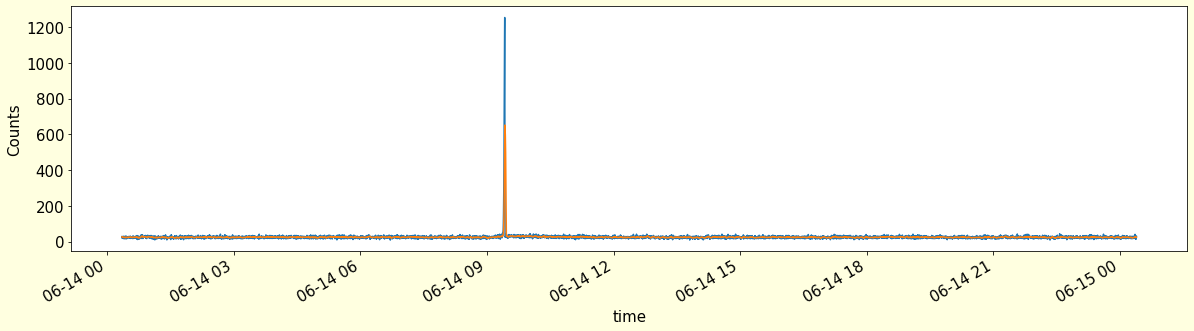

In [172]:
histogram['flux'] = histogram.loc[:,0:1023].sum(axis=1)

plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

histogram['roll'] = histogram['flux'].rolling(10).mean()

plt.ylabel('Counts')

histogram['flux'].plot()
histogram['roll'].plot()

## Plot Energy

/tmp/ipykernel_18970/251897004.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc['2023-06-14 09:24:00':'2023-06-14 10:26:00']


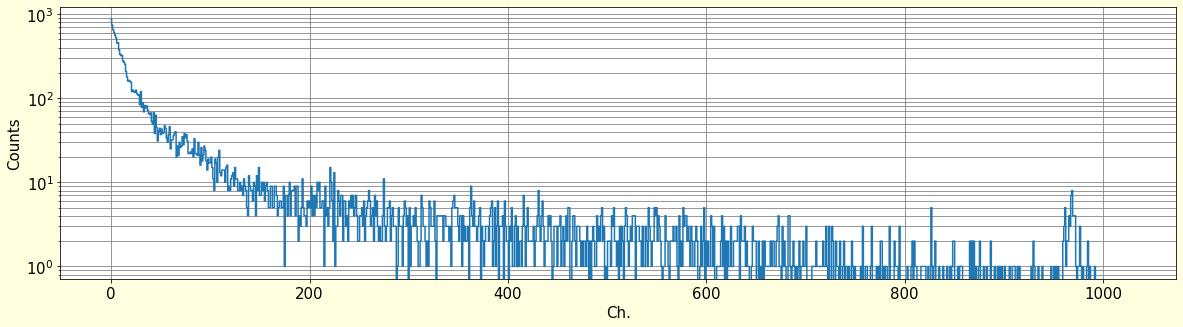

In [173]:
yy = histogram.copy()
#yy = yy.loc['2023-03-27 11:00:00':'2023-03-27 13:00:00']
yy = yy.loc['2023-06-14 09:24:00':'2023-06-14 10:26:00']
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()

plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

plt.plot(ener[0], drawstyle='steps-mid')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(which='minor', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([90,150])


## Plot Detail

/tmp/ipykernel_8830/1830661238.py:15: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  histogram.loc[FROM:TO,'flux'].plot(marker='o', label='GEODOS')
/tmp/ipykernel_8830/1830661238.py:16: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  histogram.loc[FROM:TO,'roll'].plot()


Text(0.5, 0, 'Time')

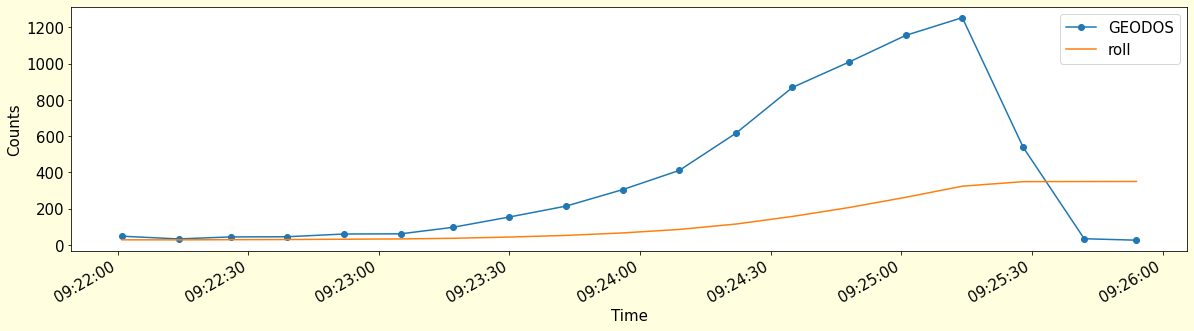

In [31]:
FROM = '2023-05-30 14:00'
TO = '2023-05-30 16:00'
FROM = '2023-06-08 9:30:00'
TO = '2023-06-08 13:00:00'
FROM = '2023-06-14 9:22:00'
TO = '2023-06-14 9:26:00'
#FROM = '2023-05-30 9:00'
#TO = '2023-05-30 11:00'
histogram['flux'] = histogram.loc[:,0:1000].sum(axis=1)
#histogram['flux'] = histogram.loc[:,24:26].sum(axis=1)
histogram['roll'] = histogram['flux'].rolling(20).mean()
plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})
histogram.loc[FROM:TO,'flux'].plot(marker='o', label='GEODOS')
histogram.loc[FROM:TO,'roll'].plot()

#plt.ylim(20,100)
plt.legend()
plt.ylabel('Counts')
plt.xlabel('Time')


/tmp/ipykernel_18970/4200466924.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc[FROM:TO]


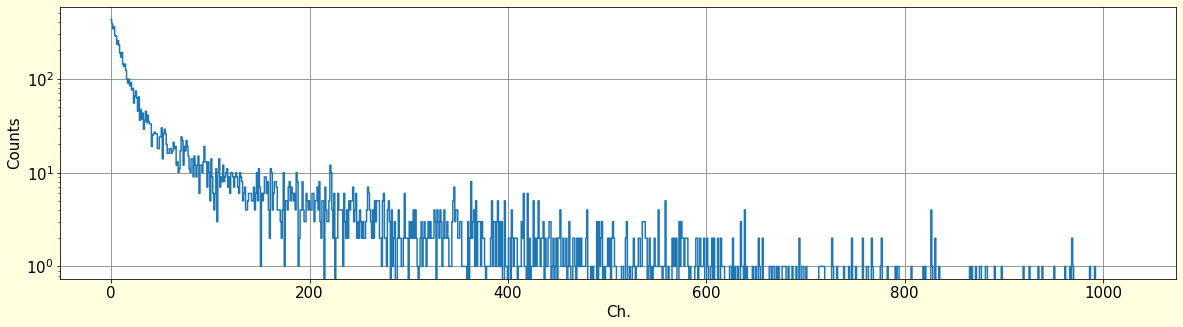

In [165]:
yy = histogram.copy()
yy = yy.loc[FROM:TO]
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()

plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

plt.plot(ener[0], drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([10,100])

In [126]:
yy1 = histogram.copy()
#yy = histogram.copy()


/tmp/ipykernel_27864/2058311576.py:11: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = histogram.loc[FROM:TO].copy()


(0.0, 300.0)

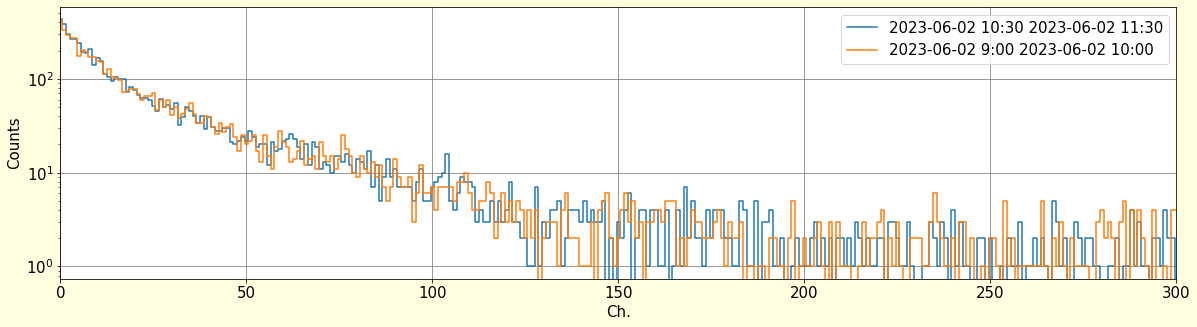

In [17]:
FROM = '2023-05-30 14:00 '
TO = '2023-05-30 16:00'
FROM1 = '2023-05-30 9:00 '
TO1 = '2023-05-30 11:00'

FROM = '2023-06-02 10:30 '
TO = '2023-06-02 11:30'
FROM1 = '2023-06-02 9:00 '
TO1 = '2023-06-02 10:00'

yy = histogram.loc[FROM:TO].copy()
yy1 = histogram.loc[FROM1:TO1].copy()
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()
ener1 = yy1.iloc[:,0:1024].sum()
ener1 = ener1.reset_index()

plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

plt.plot(ener[0], drawstyle='steps-mid', label=FROM + TO)
plt.plot(ener1[0], drawstyle='steps-mid', label=FROM1 + TO1)
#plt.plot(ener[0]/ener1[0], drawstyle='steps-mid', label=FROM1 + TO1)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
plt.legend()
plt.xlim([0,300])

In [174]:
histogram.loc[:,23:26]

,23,24,25,26
time,,,,
2023-05-30 22:50:45,0.0,0.0,0.0,0.0
2023-05-30 22:50:57,1.0,0.0,0.0,0.0
2023-05-30 22:51:10,1.0,0.0,0.0,0.0
2023-05-30 22:51:22,0.0,0.0,0.0,1.0
2023-05-30 22:51:35,0.0,0.0,0.0,0.0
...,...,...,...,...
2023-05-30 13:48:58,0.0,0.0,0.0,0.0
2023-05-30 13:49:10,0.0,0.0,0.0,0.0
2023-05-30 13:49:23,0.0,1.0,0.0,1.0


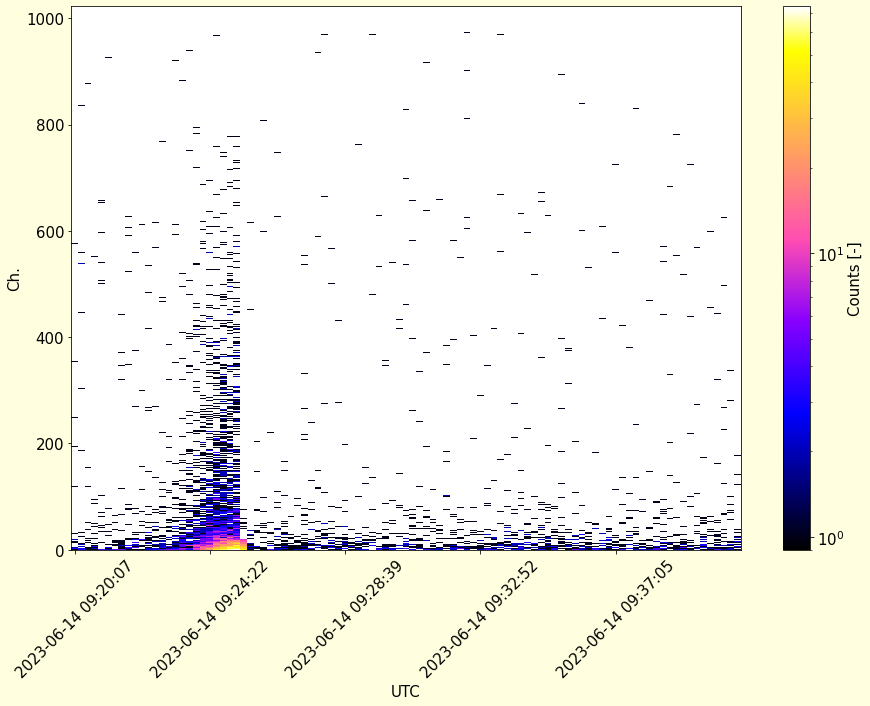

In [224]:
yy = histogram.copy()
#yy.set_index('UTC', inplace = True, drop=False)
yy.sort_index(inplace=True)

FROM = '2023-05-30 10:00'
TO = '2023-05-30 22:00'
FROM = '2023-06-14 9:20'
TO = '2023-06-14 9:40'

yy = yy.loc[FROM:TO]
plt.figure(figsize=(15,10), facecolor='lightyellow')

#orig_map=plt.cm.get_cmap('gnuplot2')
#reversed_map = orig_map.reversed()

#plt.imshow( yy.iloc[:,0:1023].T, aspect='auto', origin='lower', cmap = 'gnuplot2', norm=LogNorm(vmin=0.1), interpolation='none')#norm=colors.LogNorm()) # , cmap = 'autumn') 
plt.imshow( yy.iloc[:,0:1023].T, aspect='auto', origin='lower', cmap = 'gnuplot2', norm=LogNorm(vmin=0.9), interpolation='none')#norm=colors.LogNorm()) # , cmap = 'autumn') 
plt.ylabel('Ch.')
plt.xlabel('UTC')
plt.colorbar(label='Counts [-]')
x1 = [0,20,40,60,80]
squad = [str(yy.iloc[x1[0]].time.round(freq='S')),str(yy.iloc[x1[1]].time.round(freq='S')),str(yy.iloc[x1[2]].time.round(freq='S')),str(yy.iloc[x1[3]].time.round(freq='S')),str(yy.iloc[x1[4]].time.round(freq='S'))]
plt.xticks(x1, squad, rotation=45)

'''
y1 = list(range(0,7))
y2 = ['']*7
for i in range(len(y1)):  
    y2[i] = str(round(113.2*y1[i]+473.46))
plt.yticks(y1, y2, rotation=0)
'''
None


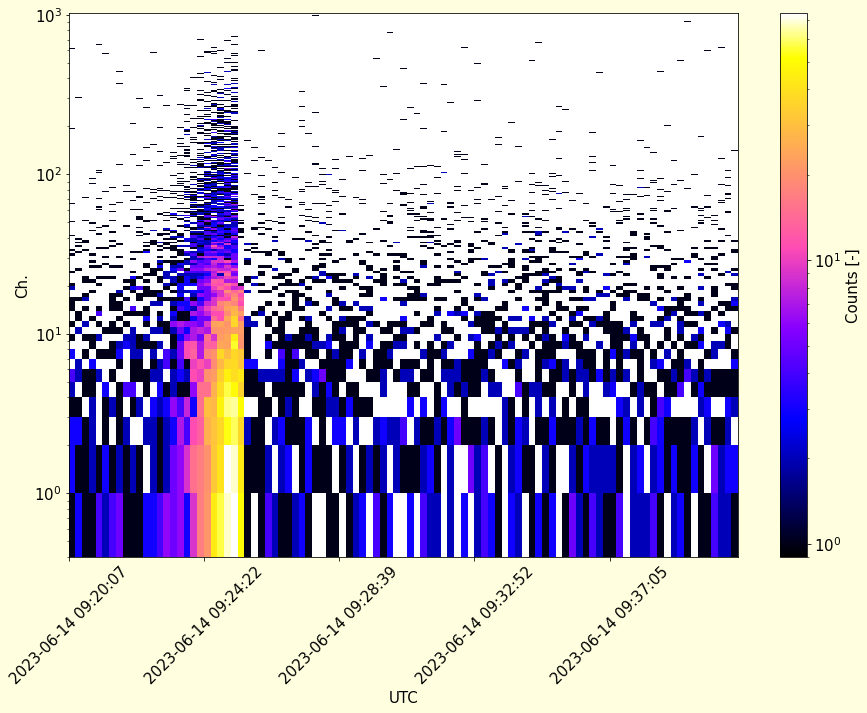

In [243]:
plt.figure(figsize=(15,10), facecolor='lightyellow')

plt.pcolormesh(yy.iloc[:,0:1023].T, cmap = 'gnuplot2', norm=LogNorm(vmin=0.9))
plt.yscale('log')
plt.ylim(0.4,1024)

x1 = [0,20,40,60,80]
squad = [str(yy.iloc[x1[0]].time.round(freq='S')),str(yy.iloc[x1[1]].time.round(freq='S')),str(yy.iloc[x1[2]].time.round(freq='S')),str(yy.iloc[x1[3]].time.round(freq='S')),str(yy.iloc[x1[4]].time.round(freq='S'))]
plt.xticks(x1, squad, rotation=45)

plt.ylabel('Ch.')
plt.xlabel('UTC')
plt.colorbar(label='Counts [-]')


In [40]:
events = pd.DataFrame(columns=['time', 'energy'])


try:
    for i in range(len(hits)):
        for j in range(hits.iloc[i,1]):
            event_ch = hits.iloc[i,j*2+3]
            event_time = hits.iloc[i,j*2+2]
            #etime = hist.iloc[i].UTC - pd.Timedelta(microseconds=64*(65535*4-event_time))
            etime = hits.iloc[i].UTC - pd.Timedelta(microseconds=54*65535*4) + pd.Timedelta(microseconds=53*event_time)
            events = pd.concat([events, pd.DataFrame.from_records([{'time':etime, 'energy':event_ch}])])

except:
    print(i,j)
    raise
            
events.set_index('time', drop=False, inplace=True)
events.sort_index(inplace=True)

0 15


TypeError: 'str' object cannot be interpreted as an integer

In [39]:
NOISE_LEVEL = 11
LAST_CHANNEL = 18
WINDOW = 20

xx = histogram

FROM = '2023-05-30 10:00'
TO = '2023-05-30 22:00'

xx = xx.loc[FROM:TO].copy()
#blitz_x = blitz.loc[FROM:TO].copy()
events_x = events.loc[FROM:TO].copy()

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

#xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

fig, (ax6, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(15,8), facecolor='lightyellow')
ax5_twin = ax6.twinx()

ax5_twin.plot(xx['flux'], c='gray', linestyle='-', marker='.', label='GEODOS (≤ Ch. 8)', drawstyle='steps-pre')
#ax5_twin.plot(xx['flux'], c='gray', label='GEODOS')
#ax5_twin.plot(xx['fluxmean'], c='gray', label='Geodos avg')
ax5_twin.set_ylabel('Counts [-]', color='black')
#ax5.set_ylim(0,21)
ax5_twin.legend()
#ax5.set_yscale('log')
#ax5_twin.grid()
#ax5.set_xlabel('UTC')

'''
ax6.plot(blitz_x.date, blitz_x.km, ls='', marker='$🗲$', label='Blitzortung')
ax6.set_ylabel('Distance [km]', color='darkblue')
ax6.set_ylim(0,65)
ax6.grid()
#ax6.vlines(x=gps_x['timeR'], ymin=0, ymax=150, color='red', label='Trigger', lw=1, alpha=0.5)
ax6.legend(loc=9)
'''
#ax2.plot(events_x.loc[events_x.energy>0].energy, ls='', ms=10, marker='+', color='green', label='> Ch. 30')
ax2.plot(events_x.energy, ls='', ms=10, marker='o', color='green', label='GEODOS (> Ch. 8)', alpha=0.1)
ax2.set_ylabel('Channel [-]', color='green')
ax2.grid()
#ax2.set_ylim(7,40)
ax2.legend(loc=1)
ax2.set_xlabel('UTC')
ax2.tick_params(axis='x', labelrotation = 90)


/tmp/ipykernel_20039/2270225869.py:10: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  xx = xx.loc[FROM:TO].copy()


NameError: name 'events' is not defined

# Telemetry Plot

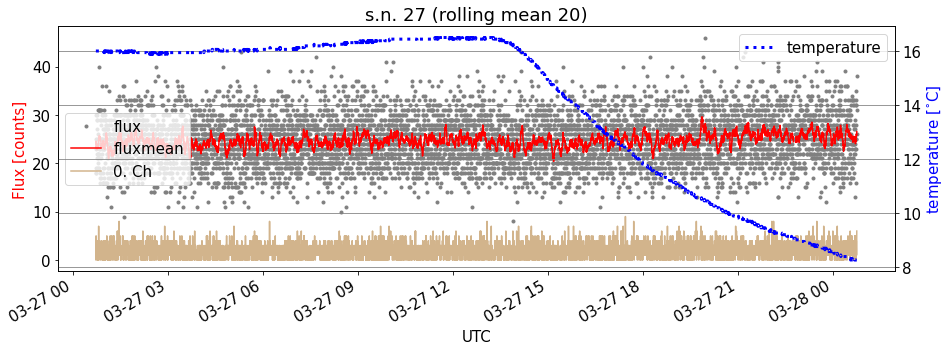

In [174]:
NOISE_LEVEL = 0
LAST_CHANNEL = 1024
WINDOW = 20

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('time', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00'] # bourka s odpalenu dobijeci eletronikou

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=6)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')
plt.legend()



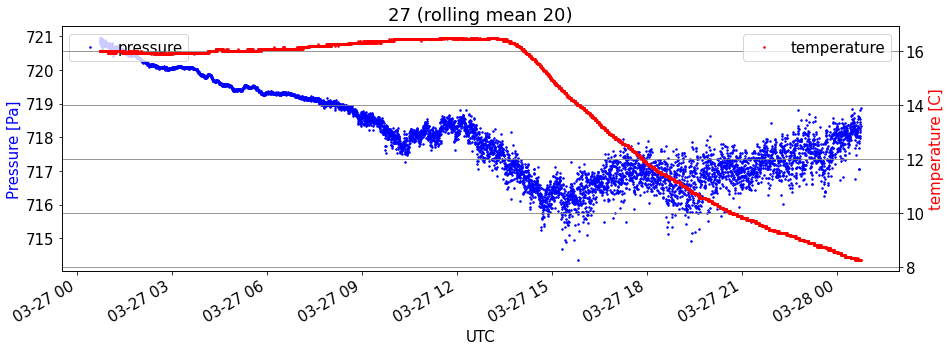

In [171]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('time', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx['pressure'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')
plt.legend()



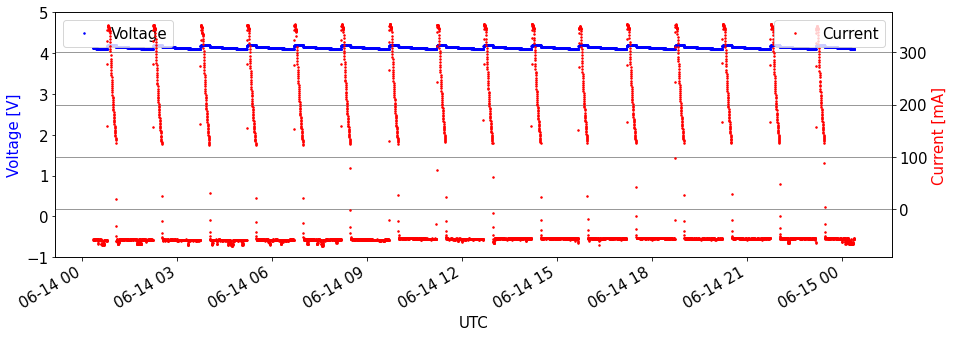

In [269]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('time', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 00:00:00':'2021-08-16 00:00:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']



xx['voltage'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'Voltage')

s = fto.split('/')
#plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([-1,5])
plt.xlabel('UTC')
plt.ylabel(r'Voltage [V]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['current'].plot(c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('Current [mA]', color='red')

plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')
plt.legend()



In [270]:
NOISE_LEVEL = 0
LAST_CHANNEL = 240
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

#xx['flux'].plot(c='gray', marker='.', linewidth=1)
xx['flux'].plot(c='blue', linewidth=1)
#xx['fluxmean'].plot(c='red')
#(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts per 15 s]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



KeyError: "None of ['UTC'] are in the columns"

<Figure size 1080x360 with 0 Axes>

# Blitzortung

In [63]:
lat = 49.1952044 # LS
lon = 20.2130544

start=pd.Timestamp('2023-06-14 09:00')
end=pd.Timestamp('2023-06-14 10:00')

print(start, end, lat, lon)
region=1
region=18
region=19

### url for json data preparation
url=[]

for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html.decode("utf-8"),lines=True)
        #blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
        blitz = pd.concat([blitz,blitz_part])
    except:
        print("No data", url[i])
        pass
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
blitz=blitz[(blitz['lon']>(lon-3.5) )&(blitz['lon']<(lon+3.5) )]

### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees
blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)

try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
    pass
#blitz['time']=blitz.index    
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

#blitz.to_csv(dto + "/blitz.csv")

print('end')

2023-06-14 09:00:00 2023-06-14 10:00:00 49.1952044 20.2130544
end


/tmp/ipykernel_18970/2974941646.py:24: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  xx = xx.loc[FROM:TO]
/tmp/ipykernel_18970/2974941646.py:25: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  lightning = blitz.loc[FROM:TO]


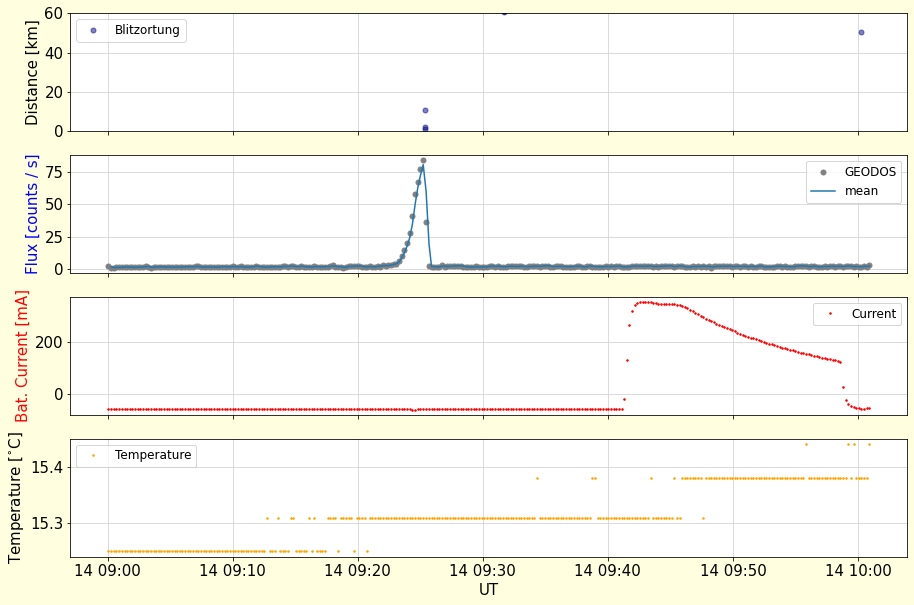

In [272]:
WINDOW = 2
NOISE_LEVEL = 0
LAST_CHANNEL = 1023

#blitz = pd.read_csv(dto + "/blitz.csv")
#blitz['date'] = pd.to_datetime(blitz['date'])
#blitz.set_index('date', inplace=True)

fig, (ax6, ax3, ax5, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,10), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 12})

FROM = '2023-06-14 09:00'
TO = '2023-06-14 10:00'

xx = histogram.copy()
#xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00'] # bourka s odpalenou elektronikou
#xx = xx.loc['2021-08-15 18:00:00':'2021-08-15 19:00:00'] # bourka s odpalenou elektronikou
#xx = xx.loc['2021-08-16 9:00:00':'2021-08-16 12:00:00'] # bourka s odpalenou elektronikou
#xx = xx.loc['2021-08-15 18:00:00':'2021-08-16 18:15:00']



xx = xx.loc[FROM:TO]
lightning = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=10, linestyle='none')
ax3.plot(xx['fluxmean']/15, label='mean')
ax3.grid(visible=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]', color='blue')
#ax3.set_yscale('log')
#ax3.set_ylim(.6,2.5)
ax3.legend(loc=1)


ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(visible=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(lightning.index, lightning.km, ls='', marker='.', ms=10, label='Blitzortung', c='darkblue', alpha=0.5)
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(visible=True, which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,60)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(visible=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


/tmp/ipykernel_18970/1909974382.py:15: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  xx = xx.loc[FROM:TO]
/tmp/ipykernel_18970/1909974382.py:16: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  lightning = blitz.loc[FROM:TO]
/tmp/ipykernel_18970/1909974382.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
/tmp/ipykernel_18970/1909974382.py:33: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax4.grid(b=True, which='major', color='lightgrey',

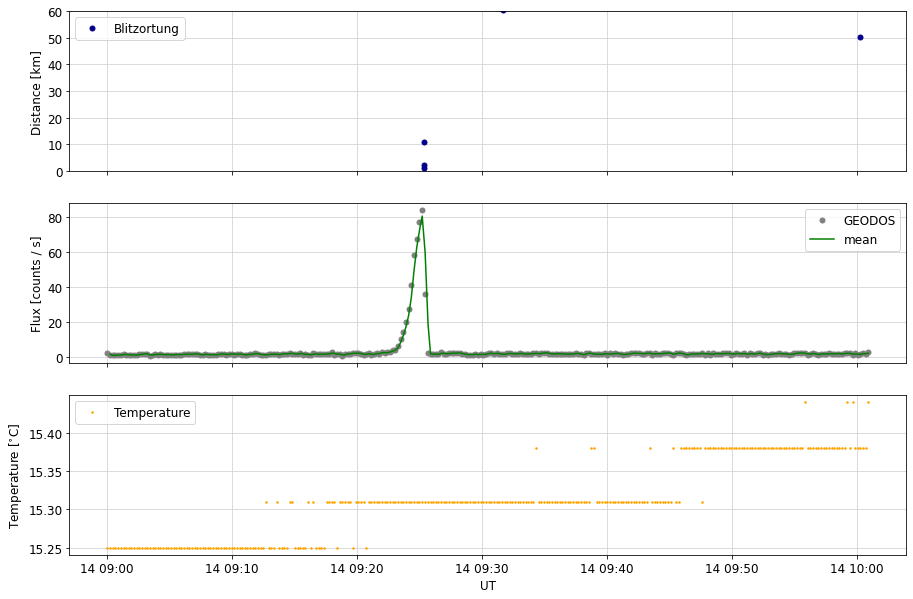

In [278]:
WINDOW = 2

#blitz = pd.read_csv(dto + "/blitz.csv")
#blitz['date'] = pd.to_datetime(blitz['date'])
#blitz.set_index('date', inplace=True)

fig, (ax6, ax3, ax4) = plt.subplots(nrows=3, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

FROM = '2023-06-14 09:00'
TO = '2023-06-14 10:00'

xx = histogram.copy()
#xx.set_index('UTC', inplace = True, drop=False)
xx = xx.loc[FROM:TO]
lightning = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=10, linestyle='none')
ax3.plot(xx['fluxmean']/15, label='mean', color='green')
ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]')
#ax3.set_yscale('log')
#ax3.set_ylim(.5,2.2)
ax3.legend()
#ax3.set_xlabel('UT')

ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(lightning.index, lightning.km, ls='', marker='.', ms=10, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,60)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


/tmp/ipykernel_18970/1762759799.py:15: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  xx = xx.loc[FROM:TO]
/tmp/ipykernel_18970/1762759799.py:16: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  lightning = blitz.loc[FROM:TO]
/tmp/ipykernel_18970/1762759799.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
/tmp/ipykernel_18970/1762759799.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax4.grid(b=True, which='major', color='lightgrey',

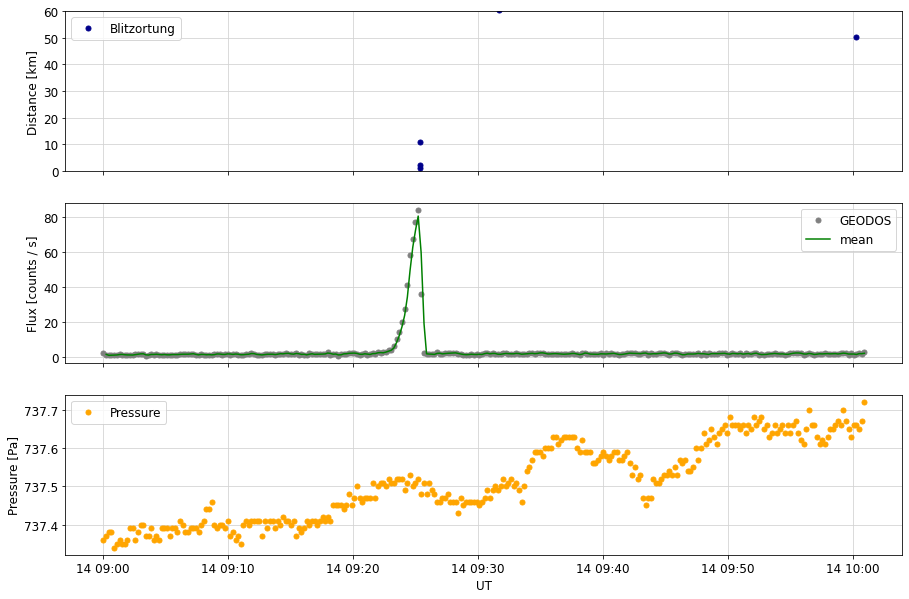

In [282]:
WINDOW = 2

#blitz = pd.read_csv(dto + "/blitz.csv")
#blitz['date'] = pd.to_datetime(blitz['date'])
#blitz.set_index('date', inplace=True)

fig, (ax6, ax3, ax4) = plt.subplots(nrows=3, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

FROM = '2023-06-14 09:00'
TO = '2023-06-14 10:00'

xx = histogram.copy()
#xx.set_index('UTC', inplace = True, drop=False)
xx = xx.loc[FROM:TO]
lightning = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=10, linestyle='none')
ax3.plot(xx['fluxmean']/15, label='mean', color='green')
ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]')
#ax3.set_yscale('log')
#ax3.set_ylim(.5,2.2)
ax3.legend()
#ax3.set_xlabel('UT')


ax4.plot(xx['pressure'], c='orange', label='Pressure', marker='.', ms=10, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Pressure [Pa]')
ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(lightning.index, lightning.km, ls='', marker='.', ms=10, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,60)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


# Energy Spectrum

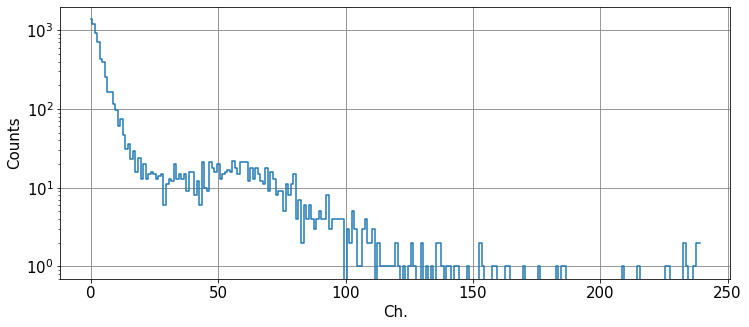

In [41]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)
#yy = yy.loc['2021-08-15 11:00:00':'2021-08-16 18:00:00']
yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,0:240].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([10,100])

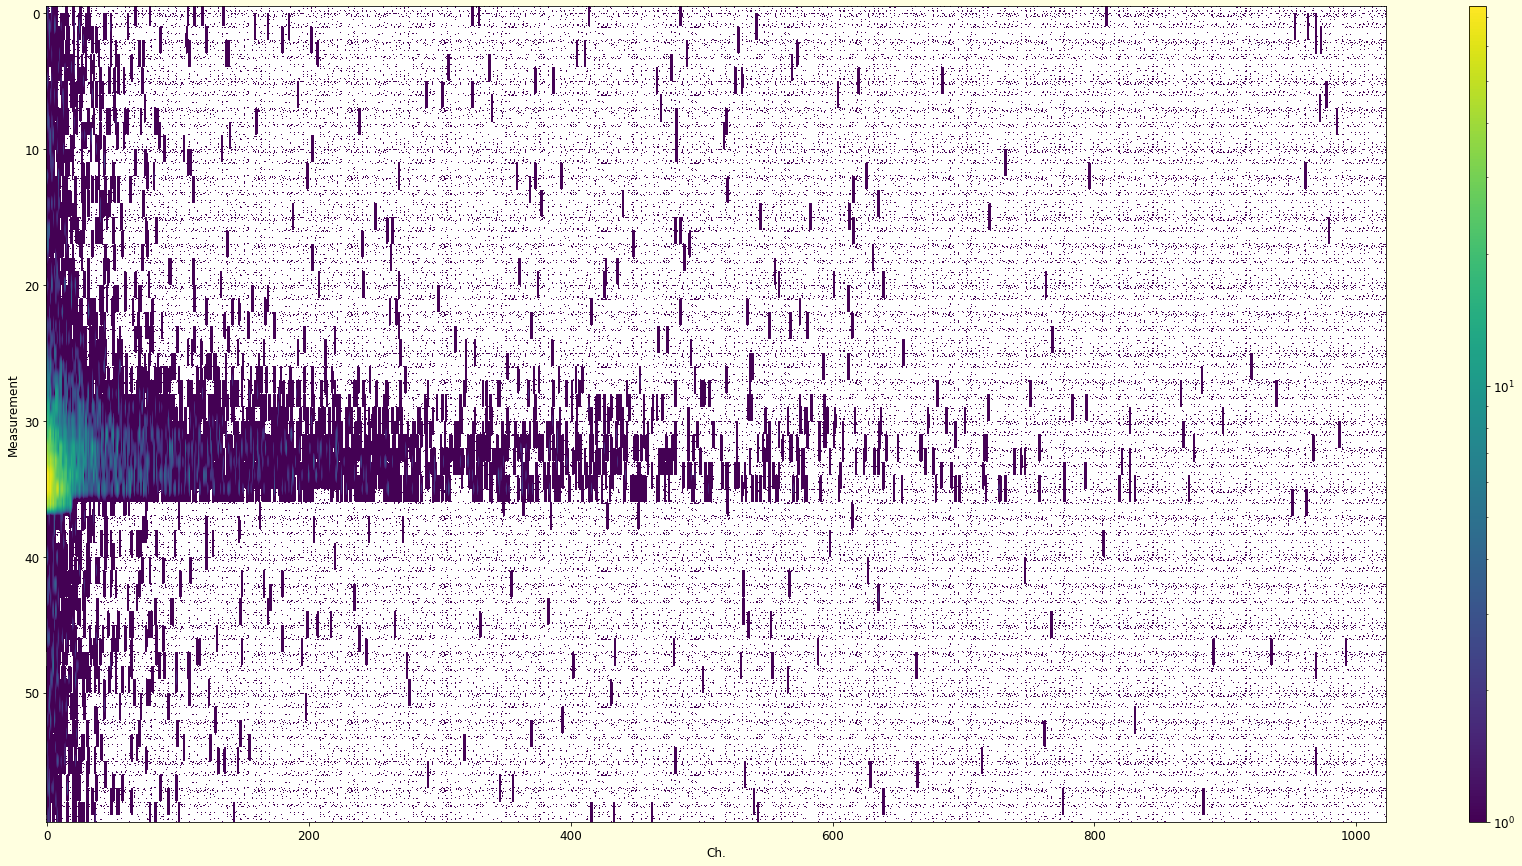

In [155]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(30, 15), facecolor='lightyellow')
plt.imshow((histogram.iloc[3940:4000,:1023]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
plt.xlabel('Ch.')
plt.ylabel('Measurement')

None

In [156]:
histogram

,0,1,2,3,4,5,6,7,8,9,...,1021,1022,1023,temperature,pressure,voltage,current,time,flux,roll
time,,,,,,,,,,,,,,,,,,,,,
2023-06-14 16:22:54,1.0,2.0,0.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,15.81,738.21,4.13,-56.0,2023-06-14 16:22:54,18.0,NaN
2023-06-14 16:23:06,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,15.81,738.21,4.13,-56.0,2023-06-14 16:23:06,27.0,NaN
2023-06-14 16:23:19,1.0,3.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,15.81,738.17,4.13,-56.0,2023-06-14 16:23:19,27.0,NaN
2023-06-14 16:23:32,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,15.81,738.16,4.13,-56.0,2023-06-14 16:23:32,28.0,NaN
2023-06-14 16:23:44,0.0,0.0,3.0,3.0,2.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,15.81,738.17,4.13,-56.0,2023-06-14 16:23:44,29.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-14 15:21:47,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,15.75,738.19,4.12,-56.0,2023-06-14 15:21:47,18.0,22.7
2023-06-14 15:21:59,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,15.75,738.16,4.12,-55.0,2023-06-14 15:21:59,24.0,22.8
2023-06-14 15:22:12,3.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,15.75,738.19,4.12,-56.0,2023-06-14 15:22:12,21.0,23.1


# Events

In [72]:
# vynulovani cisel, ktere tam da zahadne parser
hits = df.loc[df[1]=='$HITS'].copy()
hits.reset_index(inplace=True, drop=True)
hits = hits.fillna(0).copy()
hits.loc[:,2:520] = hits.loc[:,2:520].astype(int) 
'''
for index, row in hits.iterrows():
    start_index = row[2]*2+2
    columns_to_zero = hits.columns[start_index:500]
    hits.loc[index, columns_to_zero] = np.zeros_like(hits.loc[index, columns_to_zero])
'''

'\nfor index, row in hits.iterrows():\n    start_index = row[2]*2+2\n    columns_to_zero = hits.columns[start_index:500]\n    hits.loc[index, columns_to_zero] = np.zeros_like(hits.loc[index, columns_to_zero])\n'

In [69]:
events = hits.iloc[:,4::2].fillna(0).copy()
events_time = hits.iloc[:,3::2].fillna(0).copy()
events_time['start'] = pd.to_datetime(hits.iloc[:,0],unit='s')

events.reset_index(inplace=True, drop=True)
events.columns = list(range(events.shape[1]))
events_time.reset_index(inplace=True, drop=True)
events_time.columns = list(range(events_time.shape[1]))


In [74]:
# Převod hodnoty ve sloupci "Start" na datetime
events_time['Start'] = pd.to_datetime(events_time.iloc[:,-1])

# Nahrazení hodnot ve sloupcích 1 až 10 absolutním časem
for column in hits.columns[0:500]:
    events_time[column] = events_time['Start'] - pd.to_timedelta(99999*100,unit='us') + pd.to_timedelta(events_time[column]*100, unit='us')

In [76]:
ev = events.iloc[:,:500].values.flatten()
evtt = events_time.iloc[:,:500].values.flatten()

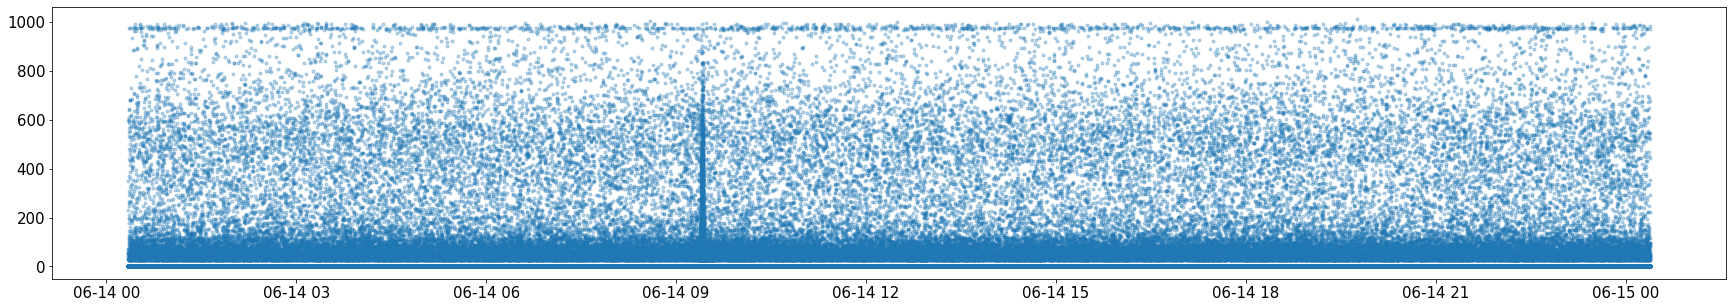

In [77]:
plt.figure(figsize=(30,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

plt.scatter(evtt, ev, marker='.', alpha=0.3)
#plt.ylim(0,250)
#plt.xlim('2022-06-24 11:00:00','2022-06-24 20:00:00')

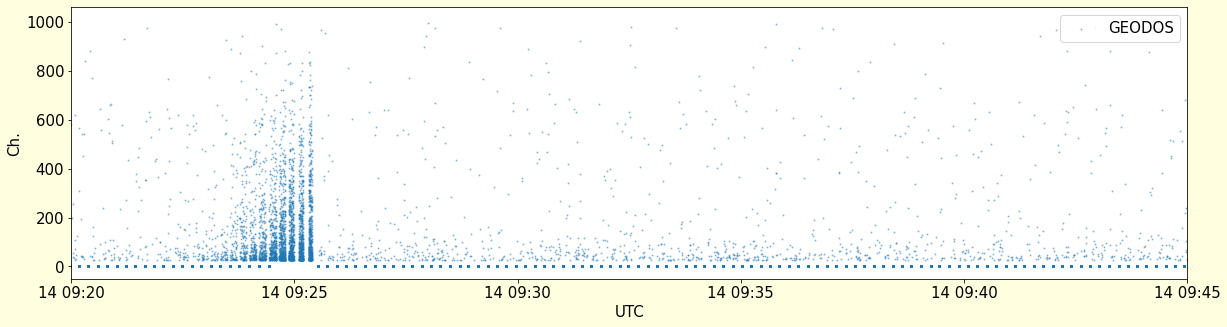

In [265]:
plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

plt.scatter(evtt, ev, marker='o', alpha = 0.4, s=1, label='GEODOS')
#plt.ylim(20,260)
#plt.xlim(pd.to_datetime('2022-06-24 14:14:00'),pd.to_datetime('2022-06-24 14:14:50'))
plt.xlim(pd.to_datetime('2023-06-14 9:20:00'),pd.to_datetime('2023-06-14 09:45:00'))
#plt.xlim(pd.to_datetime('2023-06-14 9:25:00'),pd.to_datetime('2023-06-14 09:26:00'))
plt.xlabel('UTC')
plt.ylabel('Ch.')
#plt.yscale('log')
plt.legend(loc=1)


(0.0, 80.0)

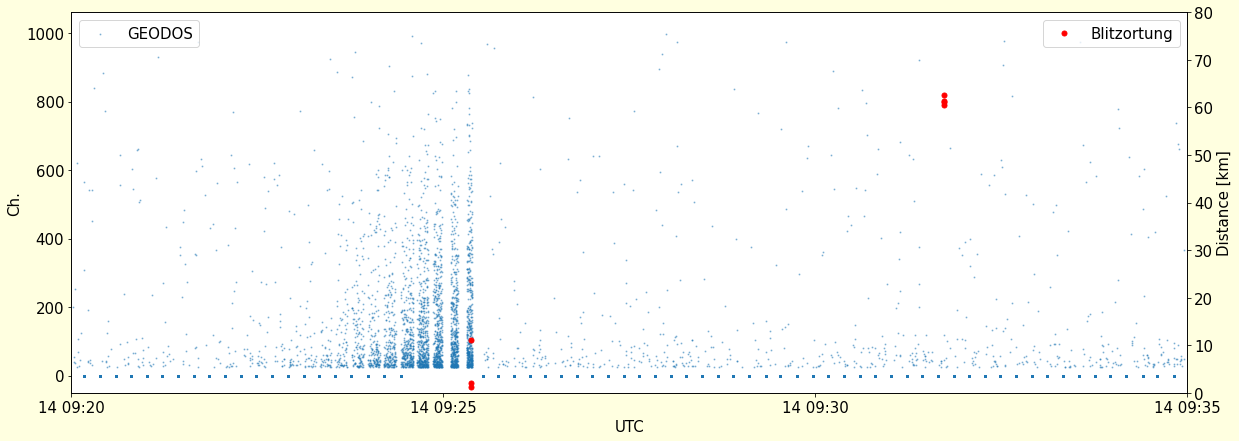

In [306]:
plt.figure(figsize=(20,7), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

plt.scatter(evtt, ev, marker='o', alpha = 0.4, s=1, label='GEODOS')
#plt.ylim(20,260)
#plt.xlim(pd.to_datetime('2022-06-24 14:14:00'),pd.to_datetime('2022-06-24 14:14:50'))
plt.xlim(pd.to_datetime('2023-06-14 9:20:00'),pd.to_datetime('2023-06-14 09:35:00'))
#plt.xlim(pd.to_datetime('2023-06-14 9:25:00'),pd.to_datetime('2023-06-14 09:26:00'))
plt.xlabel('UTC')
plt.ylabel('Ch.')
#plt.yscale('log')
plt.legend(loc=2)

plt.twinx()

plt.plot(lightning.index, lightning.km, ls='', marker='.', ms=10, label='Blitzortung', c='red')
plt.ylabel('Distance [km]')
plt.legend(loc=1)
plt.ylim(0,80)


(19522.390277777777, 19522.39340277778)

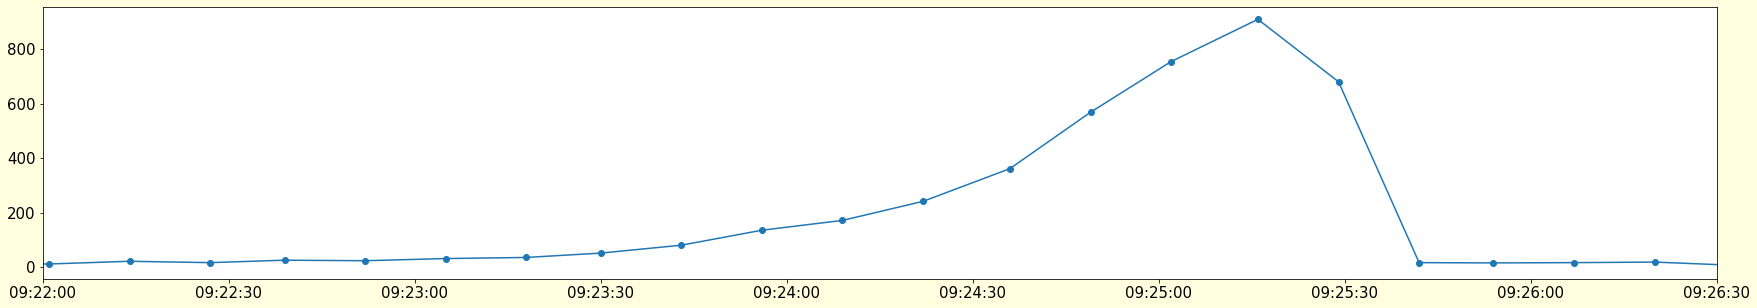

In [134]:
plt.figure(figsize=(30,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#hits.set_index('time', inplace=True, drop=False)
hits.sort_index(inplace=True)
plt.plot(hits.iloc[:,2], marker='o')
plt.xlim(pd.to_datetime('2023-06-14 9:22:0'),pd.to_datetime('2023-06-14 9:26:30'))


In [126]:
hits.set_index('time', inplace=True)

In [127]:
hits

,0,1,2,3,4,5,6,7,8,9,...,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038
time,,,,,,,,,,,,,,,,,,,,,
2023-06-14 16:22:54,1686759774,$HITS,4,8338,95,57994,80,62580,750,84432,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-14 16:23:07,1686759787,$HITS,14,7193,55,7823,269,11692,28,12839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-14 16:23:19,1686759799,$HITS,14,5831,246,20185,377,21911,111,22871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-14 16:23:32,1686759812,$HITS,18,10512,33,16742,575,20409,90,23048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-14 16:23:45,1686759825,$HITS,14,137,45,9228,129,11690,392,14746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-14 15:21:47,1686756107,$HITS,12,10799,447,21485,42,26190,36,30798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-14 15:21:59,1686756119,$HITS,7,32006,50,44847,447,45388,39,65033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-14 15:22:12,1686756132,$HITS,15,5316,29,5859,115,8109,35,11039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Resetitko LS

In [283]:
dto = '/storage/stations/LS/resetitko/2023/06/14/'

df = pd.DataFrame()
  
for fto in glob.iglob(dto + '*'): # generator, search immediate subdirectories 
    print(fto)
    l=[]
    l.extend(range(0,100))
    #rdf = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='c')
    rdf = pd.read_table(fto, sep=',', header=None, comment='*',engine='c')
    df = pd.concat([df, rdf])
    
    
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)


/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_02
/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_08
/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_23
/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_11
/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_16
/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_05
/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_01
/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_20
/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_12
/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_18
/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_15
/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_06
/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_04
/storage/stations/LS/resetitko/2023/06/14/resetitko.csv.2023-06-14_17
/storage/stations/LS

In [87]:
df

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,1679935084,$CANDY,57741,628546,52100,0,254,0,9454,27098,...,0,0,0,0,0,0,0,0,0,0
1,1679935095,$CANDY,57742,628557,52088,0,254,0,9588,26850,...,0,0,0,0,0,0,0,0,0,0
2,1679935105,$CANDY,57743,628568,52140,1,254,0,9461,26892,...,0,0,0,0,0,0,0,0,0,0
3,1679935116,$CANDY,57744,628579,52140,0,255,0,9435,26980,...,0,0,0,0,0,0,0,0,0,0
4,1679935127,$CANDY,57745,628589,52079,0,255,0,9605,26793,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,1679931426,$CANDY,57405,624888,51997,1,253,0,9253,27072,...,0,0,0,0,0,0,0,0,0,0
327,1679931437,$CANDY,57406,624899,52057,1,254,0,8993,27335,...,0,0,0,0,0,0,0,0,0,0
328,1679931448,$CANDY,57407,624910,52033,1,255,0,8907,27383,...,0,0,0,0,0,0,0,0,0,0
329,1679931459,$CANDY,57408,624921,52045,3,254,0,9134,27220,...,0,0,0,0,0,0,0,0,0,0


In [284]:
hist = df.loc[df[1]=='$CANDY'].iloc[:,12:]
hist['time'] = df.loc[df[1]=='$CANDY'].iloc[:,0]
hist['time'] = pd.to_datetime(hist['time'], unit='s')
hist.set_index('time', drop=False, inplace=True)
hist['flux'] = hist.loc[:,17:36].sum(axis=1)


(19522.390277777777, 19522.39375)

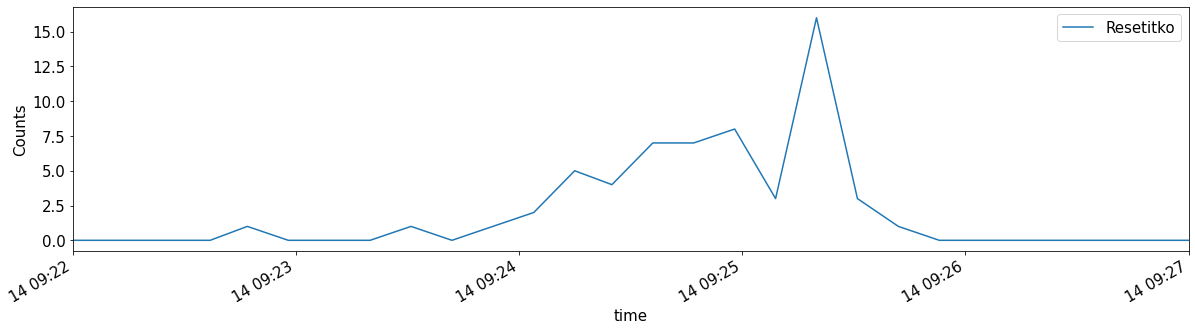

In [287]:
plt.figure(figsize=(20,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

hist['roll'] = hist['flux'].rolling(10).mean()

plt.ylabel('Counts')

hist['flux'].plot(label='Resetitko')
#hist['roll'].plot()
plt.legend()
#plt.xlim('2023-06-14 09:00','2023-06-14 10:00')
plt.xlim('2023-06-14 09:22','2023-06-14 09:27')

/tmp/ipykernel_18970/875598850.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc['2023-06-14 09:23:00':'2023-06-14 09:26:00']
/tmp/ipykernel_18970/875598850.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ener = yy.iloc[:,0:1024].sum()
/tmp/ipykernel_18970/875598850.py:21: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc['2023-06-14 09:17:00':'2023-06-14 09:20:00']
/tmp/ipykernel_18970/875598850.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select 

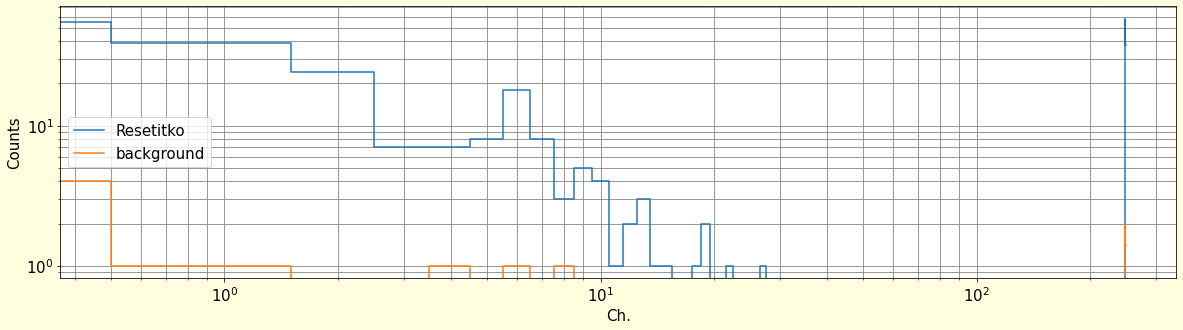

In [297]:
yy = hist.copy()
yy = yy.loc['2023-06-14 09:23:00':'2023-06-14 09:26:00']
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()

plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

plt.plot(ener[0], drawstyle='steps-mid', label='Resetitko')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(which='minor', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([90,150])

yy = hist.copy()
yy = yy.loc['2023-06-14 09:17:00':'2023-06-14 09:20:00']
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()


plt.plot(ener[0], drawstyle='steps-mid', label='background')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(which='minor', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([90,150])
plt.legend()



/tmp/ipykernel_18970/849095514.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc['2023-06-14 09:24:00':'2023-06-14 09:30:00']
/tmp/ipykernel_18970/849095514.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ener = yy.iloc[:,0:1024].sum()
/tmp/ipykernel_18970/849095514.py:21: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc['2023-06-14 09:00:00':'2023-06-14 09:20:00']
/tmp/ipykernel_18970/849095514.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select 

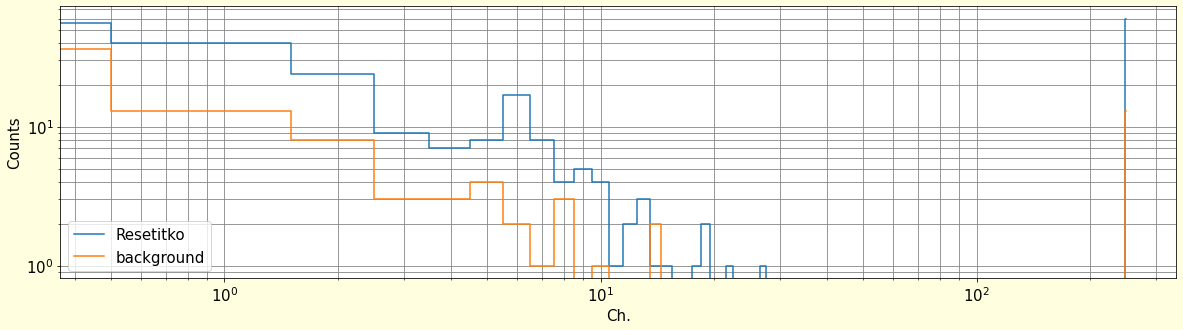

In [290]:
yy = hist.copy()
yy = yy.loc['2023-06-14 09:24:00':'2023-06-14 09:30:00']
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()

plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

plt.plot(ener[0], drawstyle='steps-mid', label='Resetitko')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(which='minor', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([90,150])

yy = hist.copy()
yy = yy.loc['2023-06-14 09:00:00':'2023-06-14 09:20:00']
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()


plt.plot(ener[0], drawstyle='steps-mid', label='background')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(which='minor', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([90,150])
plt.legend()



## EFM

/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_01
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_12
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_18
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_20
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_15
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_06
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_02
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_11
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_23
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_16
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_05
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_07
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_14
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_19
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-06-14_13
/storage/stations/LS/vezi

/tmp/ipykernel_18970/199614404.py:59: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  histogram.loc[FROM:TO,'flux'].plot(color='black',label='Flux GEODOS', alpha=0.5)


(20.0, 100.0)

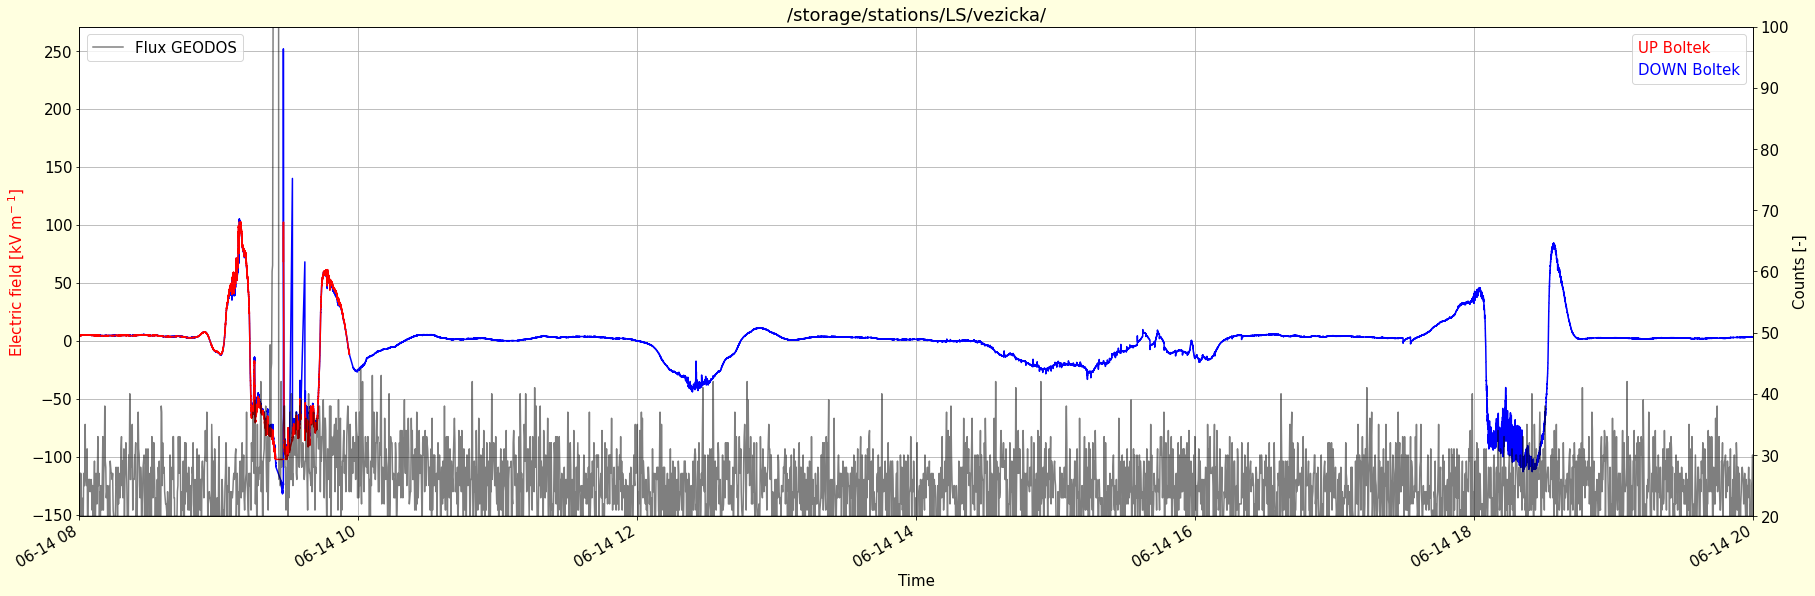

In [280]:
fto = '/storage/stations/LS/vezicka/'

ftt = glob.iglob(fto+"/**/*.csv.2023-06-14*") # generator, search immediate subdirectories 

plt.figure(figsize=(30,10), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})

for f in ftt:
    print(f)
    l=[]
    l.extend(range(0,4))
    
    df = pd.read_csv(f, sep=',', header=None, names=l, comment='*', low_memory=False, on_bad_lines='skip')

    if 'up' in f:
        label = 'UP Boltek'
        color = 'red'
        factor = 5
    else:
        label = 'DOWN Boltek'
        color = 'blue'
        factor = 4*5
   
    
    df['field'] = df[1].str.replace('$', '', regex=False)
    df['time'] = pd.to_datetime(df[0],unit='s')
    df.set_index('time', inplace=True, drop=False)
    df['field'] = pd.to_numeric(df['field'], errors='coerce')
    
    (df['field']*factor).plot(label=label, color=color)

plt.ylabel('Electric field [kV m$^-$$^1$]', color='red')
plt.title(fto)
#plt.legend()
plt.legend(['UP Boltek','DOWN Boltek'], labelcolor=['red','blue'], handlelength=0, handletextpad=0, fancybox=True) 
#plt.legend(['DOWN'], labelcolor=['blue'], handlelength=0, handletextpad=0, fancybox=True) 
plt.grid()
plt.xlabel('Time')
#plt.ylim(-20,20)
#plt.xlim('2023-05-30 10:00','2023-05-30 22:00')
#plt.xlim('2023-05-30 10:00','2023-05-30 20:00')
#plt.xlim('2023-06-02 9:00','2023-06-02 20:00')
plt.xlim('2023-06-14 8:00','2023-06-14 20:00')

plt.twinx()

FROM = '2023-05-30 10:00'
TO = '2023-05-30 22:00'
FROM = '2023-06-14 8:00'
TO = '2023-06-14 20:00'
#FROM = '2023-06-04 0:00'
#TO = '2023-06-04 23:59'
#histogram['flux'] = histogram.loc[:,25:27].sum(axis=1)
#histogram['flux'] = histogram.loc[:,200:400].sum(axis=1)
histogram['flux'] = histogram.loc[:,0:1023].sum(axis=1)
histogram['roll'] = histogram['flux'].rolling(20).mean()
matplotlib.rcParams.update({'font.size': 15})
#histogram.loc[FROM:TO,'flux'].plot(alpha=0.5, label='Flux GEODOS')
histogram.loc[FROM:TO,'flux'].plot(color='black',label='Flux GEODOS', alpha=0.5)
#histogram.loc[FROM:TO,'roll'].plot(alpha=0.5,color='orange')
plt.legend(loc=2)
#plt.legend(['Flux GEODOS'], labelcolor=['orange'], handlelength=0, handletextpad=0, fancybox=True, loc=2) 
plt.ylabel('Counts [-]')
plt.ylim(20, 100)



,0,1,2,3,4,5,6,7,8,9,...,1030,1031,1032,1033,1034,1035,1036,1037,1038,time
1,1685487045,$HITS,6,5298.0,76.0,31033.0,207.0,35494.0,129.0,59096.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 22:50:45
3,1685487057,$HITS,8,20176.0,576.0,27467.0,38.0,30848.0,374.0,42206.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 22:50:57
5,1685487070,$HITS,8,21848.0,66.0,33892.0,57.0,38210.0,486.0,43320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 22:51:10
7,1685487083,$HITS,15,22765.0,38.0,23524.0,39.0,27506.0,52.0,30000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 22:51:23
9,1685487095,$HITS,18,770.0,203.0,1185.0,289.0,3928.0,33.0,3954.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 22:51:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,1685454538,$HITS,11,17570.0,33.0,19275.0,525.0,20740.0,69.0,24872.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 13:48:58
563,1685454551,$HITS,5,25000.0,378.0,25207.0,104.0,50278.0,458.0,78324.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 13:49:11
565,1685454563,$HITS,11,19413.0,29.0,25532.0,33.0,39923.0,41.0,44702.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 13:49:23
567,1685454576,$HITS,10,1351.0,41.0,2357.0,754.0,9284.0,314.0,9521.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 13:49:36
